In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.matcher import Matcher
nlp = spacy.load('en_core_web_lg')
from spacy import displacy

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import string
import re
import os

import networkx as nx
from pypdf import PdfReader
from typing import Text
import  requests
from bs4 import BeautifulSoup
import community.community_louvain as community_louvain
from pyvis.network import Network

from tqdm import tqdm
import time

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

### Parsing a list of Characters

In [180]:
html_text = requests.get("https://rickriordan.com/characters/").text
soup = BeautifulSoup(html_text, 'lxml')
characters = soup.find_all('div', class_='character')

character_list_name = []

for character in characters:
    character_name = character.find('p', class_='character-name').text
    character_list_name.append(character_name)

In [181]:
# only taking Percy Jackson characters
character_list_name = character_list_name[:49]
character_list_name[-1]

'Travis and Connor Stoll'

In [182]:
# removing duplicate names in the list
print(f"Length of list before removing duplicates : {len(character_list_name)}")
character_list_name = set(character_list_name)
character_list_name = list(character_list_name)
print(f"Length of list after removing duplicates : {len(character_list_name)}")

Length of list before removing duplicates : 49
Length of list after removing duplicates : 36


In [183]:
# Creating a dataframe of these characters
character_df = pd.DataFrame({'characters': character_list_name})
character_df.to_csv('csv_files/characters.csv', index=False)
character_df.head()

,characters
0,Tyson
1,Percy Jackson
2,Frank Zhang
3,Annabeth Chase
4,Hazel Levesque


### Parsing ALL THE BOOKS

In [184]:
# Book names
book_names = ['1_1_lightening_thief.pdf', '1_2_sea_of_monsters.pdf', '1_3_titans_curse.pdf', '1_4_battle_of_the_labyrinth.pdf', '1_5_the_last_olympian.pdf',
               '2_1_the_lost_hero.pdf', '2_2_son_of_neptune.pdf', '2_3_mark_of_athena.pdf', '2_4_house_of_hades.pdf', '2_5_blood_of_olympus.pdf']

In [185]:
# Extracting texts from pdfs
def return_text(book_name):
    path = "books/" + str(book_name)
    reader = PdfReader(path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() + " "
    return text

In [186]:
list_of_texts = {}
for book in tqdm(book_names):
    list_of_texts[book] = return_text(book)

100%|██████████| 10/10 [02:18<00:00, 13.88s/it]


In [187]:
# book wise length (Number of characters)
for book in book_names:
    print(f"{book}: {len(list_of_texts[book])}")

1_1_lightening_thief.pdf: 507998
1_2_sea_of_monsters.pdf: 373805
1_3_titans_curse.pdf: 410336
1_4_battle_of_the_labyrinth.pdf: 485019
1_5_the_last_olympian.pdf: 506717
2_1_the_lost_hero.pdf: 732695
2_2_son_of_neptune.pdf: 723739
2_3_mark_of_athena.pdf: 782787
2_4_house_of_hades.pdf: 799899
2_5_blood_of_olympus.pdf: 663347


In [188]:
# Create a dataframe of sentences
df1 = pd.DataFrame(columns=['sentences', 'book_name'])
for book in book_names:
    print(book)
    list_of_sentences = list_of_texts[book].splitlines()
    book_list = [book[4:-4]] * len(list_of_sentences)

    df2 = pd.DataFrame({'sentences': list_of_sentences, 'book_name': book_list})
    df1 = pd.concat([df1, df2])

df1.to_csv('csv_files/sentences.csv',index=False)
df1.head()

In [220]:
sentences_df = pd.read_csv('csv_files/sentences.csv')
sentences_df.head()

,sentences,book_name
0,1 | Page,lightening_thief
1,THE LIGHTNING THIEF,lightening_thief
2,Percy Jackson and the Olympians - Book 1,lightening_thief
3,Rick Riordan,lightening_thief
4,2 | Page,lightening_thief


In [221]:
len(sentences_df)

103774

In [222]:
sentences_df = sentences_df.dropna(axis=0)
len(sentences_df)

103773

### Cleaning the data

In [223]:
nltk.download('punkt') 
stopwords_list = set(stopwords.words('english')) 

def remove_punctuations(text):
    text = str(text)
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

stopwords_list = [''.join(item for item in x if item not in string.punctuation) for x in stopwords_list] #Remove punctuation from stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [224]:
sentences_df['WordCountText'] = sentences_df['sentences'].str.lower().apply(remove_punctuations).apply(word_tokenize) # Word Text
sentences_df['WordCount'] = sentences_df['WordCountText'].str.len() #Word Count
sentences_df.head()

,sentences,book_name,WordCountText,WordCount
0,1 | Page,lightening_thief,"[1, page]",2
1,THE LIGHTNING THIEF,lightening_thief,"[the, lightning, thief]",3
2,Percy Jackson and the Olympians - Book 1,lightening_thief,"[percy, jackson, and, the, olympians, book, 1]",7
3,Rick Riordan,lightening_thief,"[rick, riordan]",2
4,2 | Page,lightening_thief,"[2, page]",2


In [225]:
# Removing titles and page numbers
indices = np.where(sentences_df['WordCountText'].apply(lambda x: len(x) > 1 and x[1] == 'page'))[0]
indices = indices.tolist()
len(indices)

221

In [226]:
# Deleting the rows at these indices
sentences_df.drop(indices, inplace=True)

# Resetting the index to maintain consistency
sentences_df.reset_index(drop=True, inplace=True)

print(f"length of df : {len(sentences_df)}")

sentences_df.head()

length of df : 103552


,sentences,book_name,WordCountText,WordCount
0,THE LIGHTNING THIEF,lightening_thief,"[the, lightning, thief]",3
1,Percy Jackson and the Olympians - Book 1,lightening_thief,"[percy, jackson, and, the, olympians, book, 1]",7
2,Rick Riordan,lightening_thief,"[rick, riordan]",2
3,1 I ACCIDENTALLY VAPORIZE,lightening_thief,"[1, i, accidentally, vaporize]",4
4,MY PRE- ALGEBRA TEACHER,lightening_thief,"[my, pre, algebra, teacher]",4


In [227]:
# Function to check if a string can be converted to a number
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

indices = np.where(sentences_df['WordCountText'].apply(lambda x: any(is_number(item) for item in x)))[0]
indices = indices.tolist()

# Print the indices
print(indices)

[1, 3, 37, 55, 91, 110, 129, 167, 182, 213, 277, 306, 369, 404, 428, 450, 503, 507, 545, 602, 640, 748, 764, 769, 774, 790, 872, 889, 925, 960, 1004, 1029, 1045, 1062, 1078, 1095, 1136, 1154, 1187, 1202, 1223, 1273, 1320, 1330, 1422, 1441, 1459, 1475, 1513, 1527, 1542, 1578, 1594, 1611, 1633, 1652, 1694, 1728, 1747, 1803, 1822, 1844, 1879, 1895, 1913, 1928, 1970, 1986, 2002, 2021, 2080, 2096, 2117, 2168, 2256, 2266, 2267, 2299, 2361, 2379, 2394, 2427, 2449, 2499, 2500, 2505, 2544, 2558, 2599, 2615, 2658, 2677, 2681, 2750, 2788, 2877, 2925, 2941, 2962, 3000, 3009, 3024, 3040, 3074, 3091, 3110, 3249, 3264, 3280, 3296, 3315, 3351, 3363, 3377, 3396, 3412, 3444, 3460, 3467, 3509, 3522, 3581, 3606, 3684, 3716, 3718, 3757, 3774, 3787, 3890, 3892, 3905, 3957, 4013, 4030, 4084, 4101, 4135, 4262, 4295, 4303, 4324, 4343, 4358, 4495, 4503, 4571, 4607, 4617, 4628, 4658, 4668, 4678, 4683, 4684, 4701, 4712, 4732, 4737, 4750, 4777, 4789, 4791, 4812, 4848, 4924, 4941, 4975, 5021, 5035, 5050, 5059, 5062

In [228]:
# Deleting the rows at these indices
sentences_df.drop(indices, inplace=True)

# Resetting the index to maintain consistency
sentences_df.reset_index(drop=True, inplace=True)

print(f"length of df : {len(sentences_df)}")

sentences_df.head()

length of df : 102886


,sentences,book_name,WordCountText,WordCount
0,THE LIGHTNING THIEF,lightening_thief,"[the, lightning, thief]",3
1,Rick Riordan,lightening_thief,"[rick, riordan]",2
2,MY PRE- ALGEBRA TEACHER,lightening_thief,"[my, pre, algebra, teacher]",4
3,"Look, I didn't want to be a half -blood.",lightening_thief,"[look, i, didnt, want, to, be, a, half, blood]",9
4,"If you're reading this because you think you might be one, my advice is: close this book right now.",lightening_thief,"[if, youre, reading, this, because, you, think, you, might, be, one, my, advice, is, close, this, book, right, now]",19


<Axes: xlabel='book_name', ylabel='WordCount'>

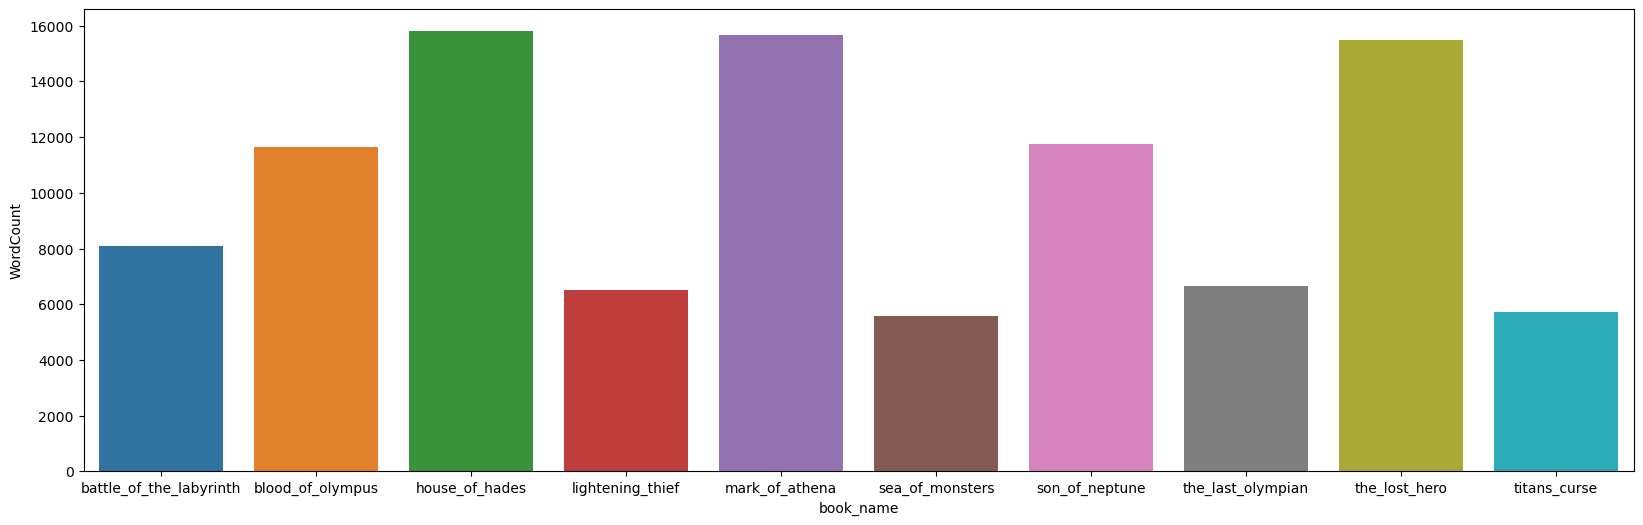

In [229]:
# Plotting the count of sentences by book
count_sen_df = sentences_df[['book_name', 'WordCount']].groupby(['book_name']).count()
count_sen_df.sort_values(by='WordCount')

plt.figure(figsize=(20,6))
sns.barplot(count_sen_df, x=count_sen_df.index, y=count_sen_df['WordCount'])

In [230]:
sentences_df['book_name'].unique()

array(['lightening_thief', 'sea_of_monsters', 'titans_curse',
       'battle_of_the_labyrinth', 'the_last_olympian', 'the_lost_hero',
       'son_of_neptune', 'mark_of_athena', 'house_of_hades',
       'blood_of_olympus'], dtype=object)

In [231]:
updated_book_names = ['lightening_thief', 'sea_of_monsters', 'titans_curse',
       'battle_of_the_labyrinth', 'the_last_olympian', 'the_lost_hero',
       'son_of_neptune', 'mark_of_athena', 'house_of_hades',
       'blood_of_olympus']

In [232]:
# Writing the 'sentences' column to a text file
count = 1
for book_name in updated_book_names:
    book_df = sentences_df[sentences_df['book_name'] == book_name]
    if count != 10:
        name_of_file = 'book_files/0' + str(count) + "_" + str(book_name) + '.txt'
    else:
        name_of_file = 'book_files/' + str(count) + "_" + str(book_name) + '.txt'
    count = count + 1 
    with open(name_of_file, 'w') as file:
        for item in book_df['sentences']:
            file.write("%s\n" % item)
    

### Character preparation

In [233]:
# Taking first names of characters
character_df = pd.read_csv('csv_files/characters.csv')

character_df['characters'] = character_df['characters'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
character_df['character_firstname'] = character_df['characters'].apply(lambda x: x.split(' ', 1)[0])
character_df = character_df[["characters", "character_firstname"]]
character_df.head(10)

,characters,character_firstname
0,Tyson,Tyson
1,Percy Jackson,Percy
2,Frank Zhang,Frank
3,Annabeth Chase,Annabeth
4,Hazel Levesque,Hazel
5,Ares,Ares
6,Zoë Nightshade,Zoë
7,Grover Underwood,Grover
8,Demeter,Demeter
9,Poseidon,Poseidon


### Using NER

In [234]:
NER = spacy.load("en_core_web_lg")

print(f"Sentence : {sentences_df['sentences'].iloc[5]}") 

NER_sentence = NER(sentences_df['sentences'].iloc[20])
displacy.render(NER_sentence, style="ent", jupyter=True)

Sentence : Believe what -ever lie your mom or dad told you about your birth, and try to lead a normal life.  


In [235]:
all_books = [b for b in os.scandir('book_files/') if '.txt' in b.name]
all_books

[<DirEntry '01_lightening_thief.txt'>,
 <DirEntry '02_sea_of_monsters.txt'>,
 <DirEntry '03_titans_curse.txt'>,
 <DirEntry '04_battle_of_the_labyrinth.txt'>,
 <DirEntry '05_the_last_olympian.txt'>,
 <DirEntry '06_the_lost_hero.txt'>,
 <DirEntry '07_son_of_neptune.txt'>,
 <DirEntry '08_mark_of_athena.txt'>,
 <DirEntry '09_house_of_hades.txt'>,
 <DirEntry '10_blood_of_olympus.txt'>]

In [236]:
%%time
NER.max_length = 2000000

book = all_books[0]
book_text = open(book).read()
book_doc = NER(book_text)

CPU times: total: 14.7 s
Wall time: 14.7 s


In [237]:
displacy.render(book_doc[0:500], style="ent", jupyter=True)

In [238]:
sentence_entity_df = []

for sentence in tqdm(book_doc.sents, 'progress'):
    entity_list = [ent.text for ent in sentence.ents]
    sentence_entity_df.append({'sentance': sentence, 'entity': entity_list})

sentence_entity_df = pd.DataFrame(sentence_entity_df)

progress: 8825it [01:05, 135.72it/s]


In [239]:
sentence_entity_df.head(20)

,sentance,entity
0,"(THE, LIGHTNING, THIEF, \n, Rick, Riordan, \n, MY, PRE-)",[Rick Riordan]
1,"(ALGEBRA, TEACHER, \n )",[]
2,"(Look, ,, I, did, n't, want, to, be, a, half, -blood, ., \n)",[]
3,"(If, you, 're, reading, this, because, you, think, you, might, be, one, ,, my, advice, is, :, close, this, book, right, now, ., \n)",[]
4,"(Believe, what, -ever, lie, your, mom, or, dad, told, you, about, your, birth, ,, and, try, to, lead, a, normal, life, ., \n)",[]
5,"(Being, a, half-, blood, is, dangerous, .)",[]
6,"(It, 's, scary, .)",[]
7,"(Most, of, the, time, ,, it, gets, you, killed, in, painful, ,, nasty, ways, ., \n)",[]
8,"(If, you, 're, a, no, rmal, kid, ,, reading, this, because, you, think, it, 's, fiction, ,, great, .)",[]
9,"(Read, on, .)",[]


### Cleaning entities

In [241]:
# Filtering entities using the character df
def filter_entity_list(entity_list, character_df):
    return [ent for ent in entity_list 
            if str(ent).split(" ")[0] in list(character_df.character_firstname)]

filter_entity_list(['Percy Jackson', 'Yash', 2], character_df)

['Percy Jackson']

In [242]:
sentence_entity_df['character_entities'] = sentence_entity_df['entity'].apply(lambda x: filter_entity_list(x, character_df))
# Filter out sentences that don't have any character entities
sentence_entity_df_filtered = sentence_entity_df[sentence_entity_df['character_entities'].map(len) > 0]
sentence_entity_df_filtered.head(10)

,sentance,entity,character_entities
15,"(My, name, is, Percy, Jackson, ., \n)",[Percy Jackson],[Percy Jackson]
38,"(All, the, way, into, the, city, ,, I, put, up, with, Nancy, Bobofit, ,, the, freckly, ,, redheaded, kleptomaniac, girl, ,, hitting, \n, my, best, friend, Grover, in, the, back, of, the, head, wit...","[Nancy Bobofit, Grover, p]",[Grover]
50,"(Grover, tried, to, calm, me, down, .)",[Grover],[Grover]
55,"(I, started, to, get, up, ,, but, Grover, pulled, me, back, to, my, seat, ., \n )",[Grover],[Grover]
110,"(Grover, and, I, were, about, to, follow, when, Mr., Brunner, said, ,, "", Mr., Jackson, ., "", \n)","[Grover, Brunner, Jackson]",[Grover]
111,"(I, told, Grover, to, keep, going, .)",[Grover],[Grover]
119,"(I, will, accept, \n, only, the, , best, from, you, ,, Percy, Jackson, ., "", \n)",[Percy Jackson],[Percy Jackson]
134,"(Grover, and, I, sat, on, the, edge, of, the, fountain, ,, away, from, the, others, .)",[Grover],[Grover]
137,"(Grover, asked, ., \n )",[Grover],[Grover]
154,"(I, was, about, to, unwrap, my, sandwich, when, Nancy, Bobofit, appeared, in, front, of, me, with, her, ugly, friends, -I, \n, guess, she, 'd, gotten, tired, of, stealing, from, the, tourists, -an...","[Nancy Bobofit, Grover]",[Grover]


### Creating Relationships

In [243]:
window_size = 14
relationships = []

for i in range(sentence_entity_df_filtered.index[-1]):
    end_i = min(i+5, sentence_entity_df_filtered.index[-1])
    char_list = sum((sentence_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicate characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [244]:
relationship_df = pd.DataFrame(relationships)
pd.set_option('display.max_rows', None)
print(len(relationship_df))
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df.head(20)

2469


,source,target
0,Chiron,Percy Jackson
1,Grover,Percy
2,Grover,Percy
3,Grover,Percy
4,Grover,Percy
5,Grover,Percy
6,Grover,Percy
7,Grover,Percy
8,Grover,Percy
9,Grover,Percy


### Renaming Entities in the relationship df

In [245]:
def replace_names_with_contains(df, simplified_names):
    # Iterate over the DataFrame and check each cell for matches
    for col in df.columns:
        df[col] = df[col].apply(lambda x: next((name for name in simplified_names if pd.notna(x) and str(name).lower() in x.lower()), x))
    return df

# Apply the replacement function to the DataFrame
new_df = replace_names_with_contains(relationship_df[['source', 'target']], list(character_df['character_firstname']))
new_df.head()

,source,target
0,Chiron,Percy
1,Grover,Percy
2,Grover,Percy
3,Grover,Percy
4,Grover,Percy


In [247]:
# Calculating Interactions
new_df["value"] = 1
relationship_df = new_df.groupby(["source","target"], sort=False, as_index=False).sum()
relationship_df.head(10)

,source,target,value
0,Chiron,Percy,167
1,Grover,Percy,159
2,Annabeth,Chiron,111
3,Annabeth,Percy,315
4,Chiron,Grover,137
5,Grover,Grover,3
6,Chiron,Hera,10
7,Annabeth,Luke,112
8,Annabeth,Clarisse,55
9,Clarisse,Percy,20


### Graphs

In [264]:
def create_graph(df, book_name):
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())

    plt.figure(figsize=(10,10))
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
    plt.show()

    
    communities = community_louvain.best_partition(G)
    nx.set_node_attributes(G, communities, 'group')
    com_net = Network(notebook = True, width="1900px", height="920px", bgcolor='#222222', font_color='white', cdn_resources='in_line')
    com_net.from_nx(G)
    com_net.show_buttons(filter_="physics")
    title = "html_files/" + str(book_name) + "community.html"
    com_net.show(title)

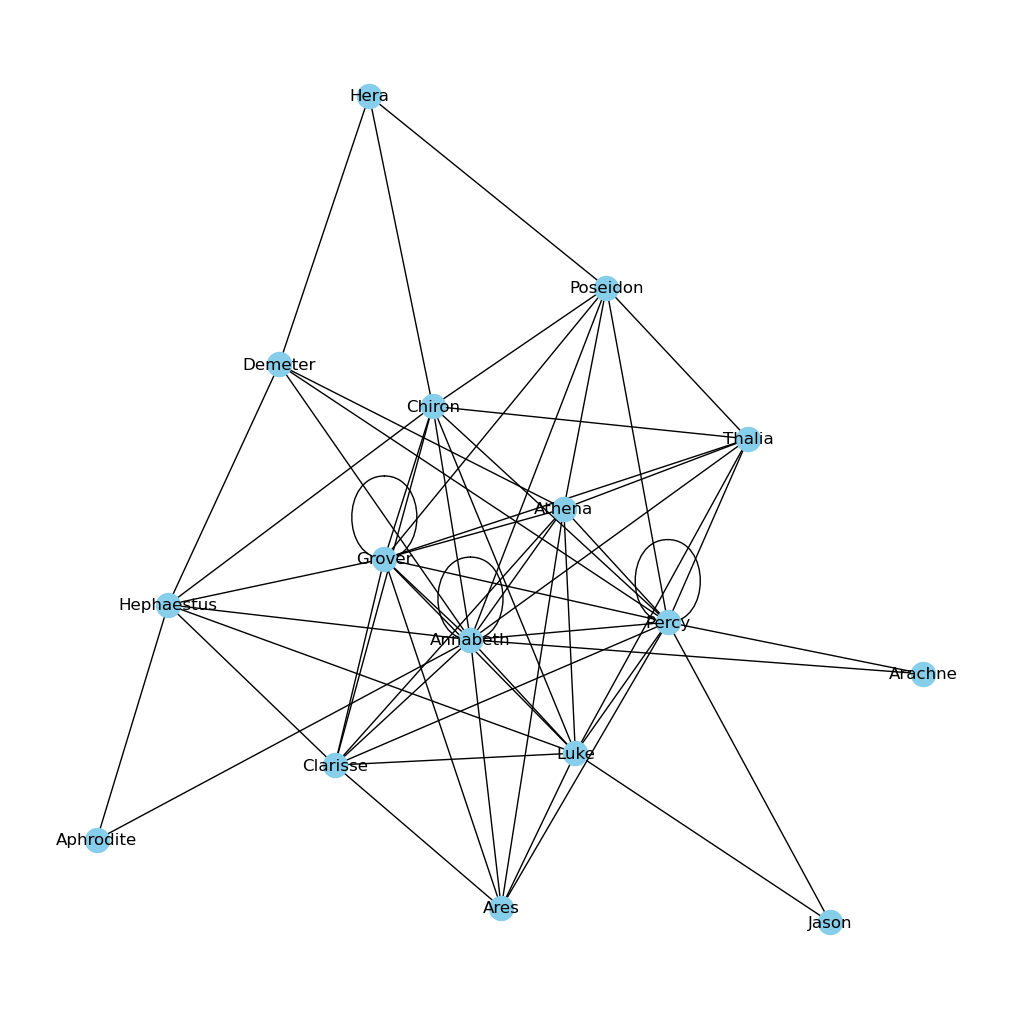

In [261]:
create_graph(relationship_df)

In [272]:
new_book_names = ['lightening_thief', 'sea_of_monsters', 'titans_curse',
       'battle_of_the_labyrinth', 'the_last_olympian', 'the_lost_hero',
       'son_of_neptune', 'mark_of_athena', 'house_of_hades',
       'blood_of_olympus']

for i in range(10):
    book_title = new_book_names[i]
    print(book_title)

lightening_thief
sea_of_monsters
titans_curse
battle_of_the_labyrinth
the_last_olympian
the_lost_hero
son_of_neptune
mark_of_athena
house_of_hades
blood_of_olympus


progress: 8825it [01:02, 140.12it/s]


2469


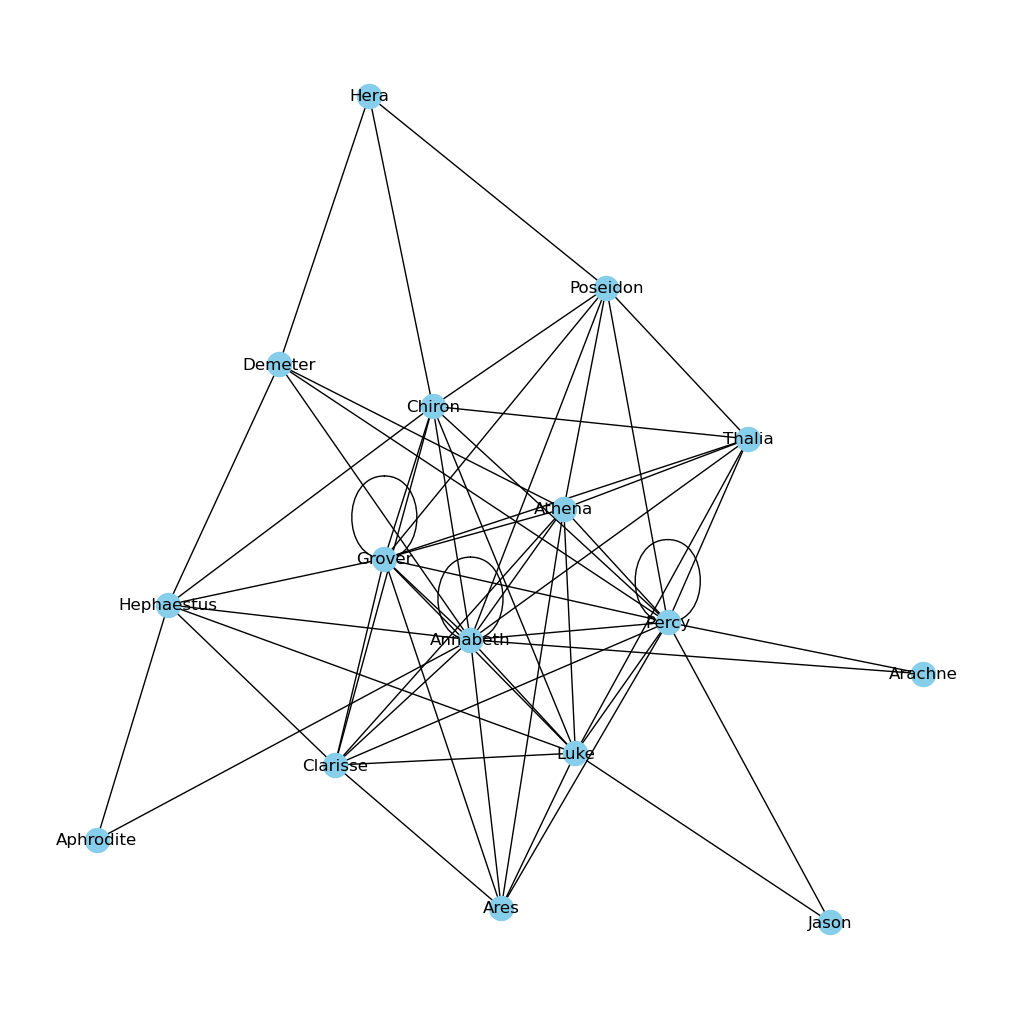

html_files/lightening_thiefcommunity.html


progress: 6342it [00:35, 176.66it/s]


2696


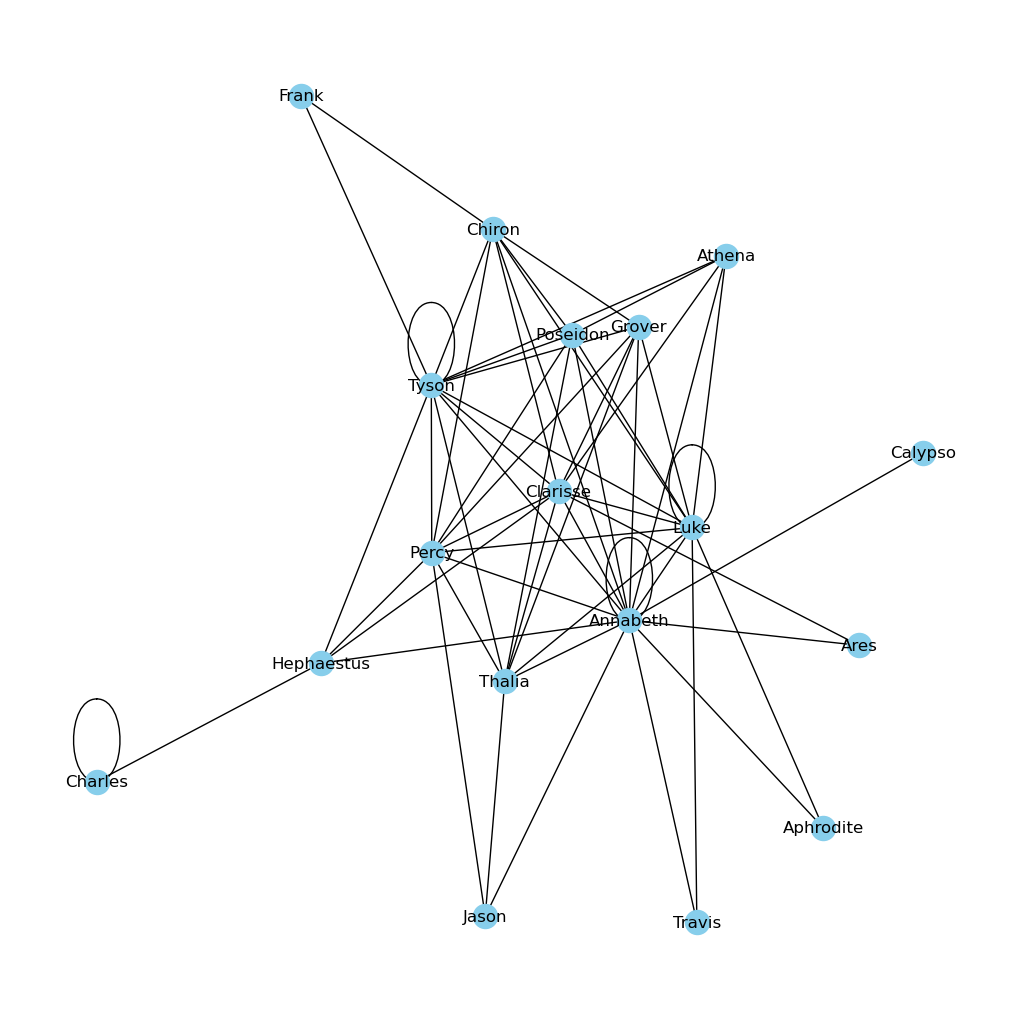

html_files/sea_of_monsterscommunity.html


progress: 8521it [01:08, 124.33it/s]


2857


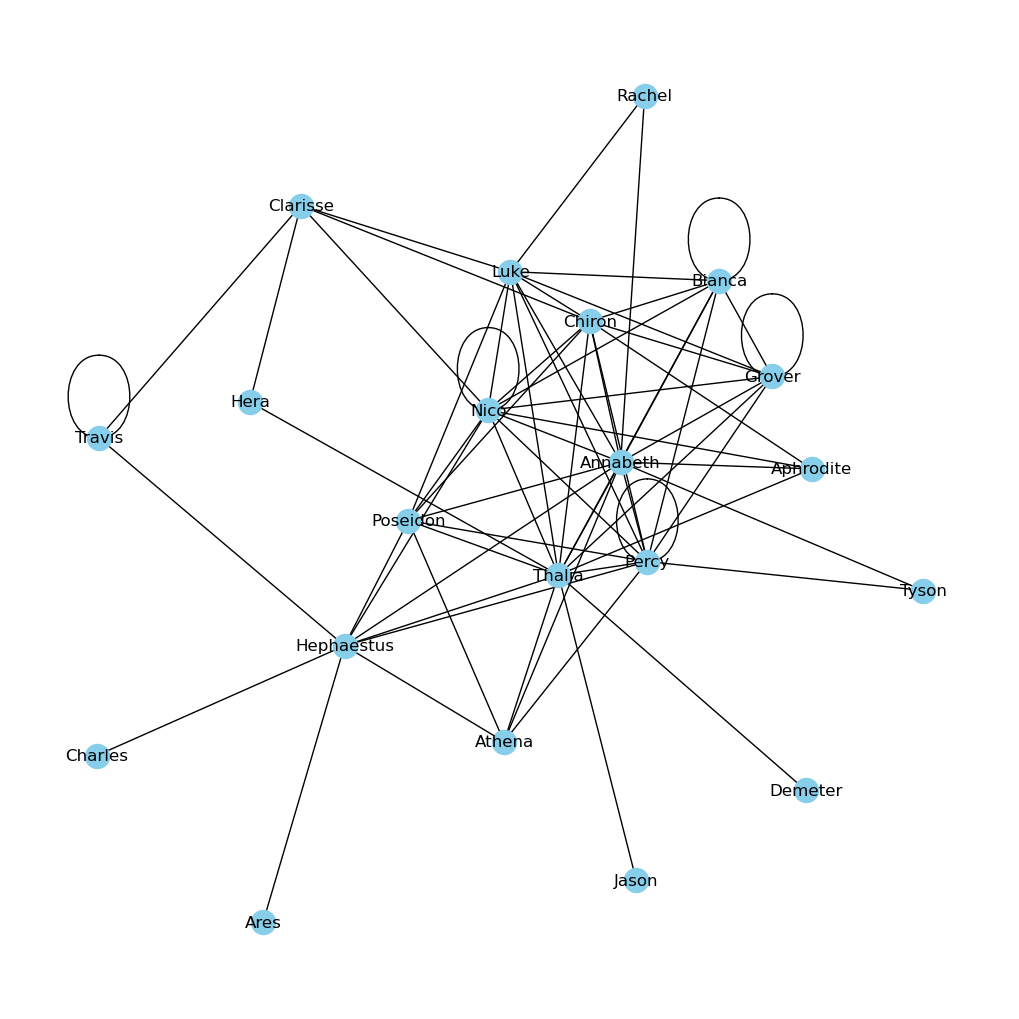

html_files/titans_cursecommunity.html


progress: 10268it [01:53, 90.30it/s] 


3805


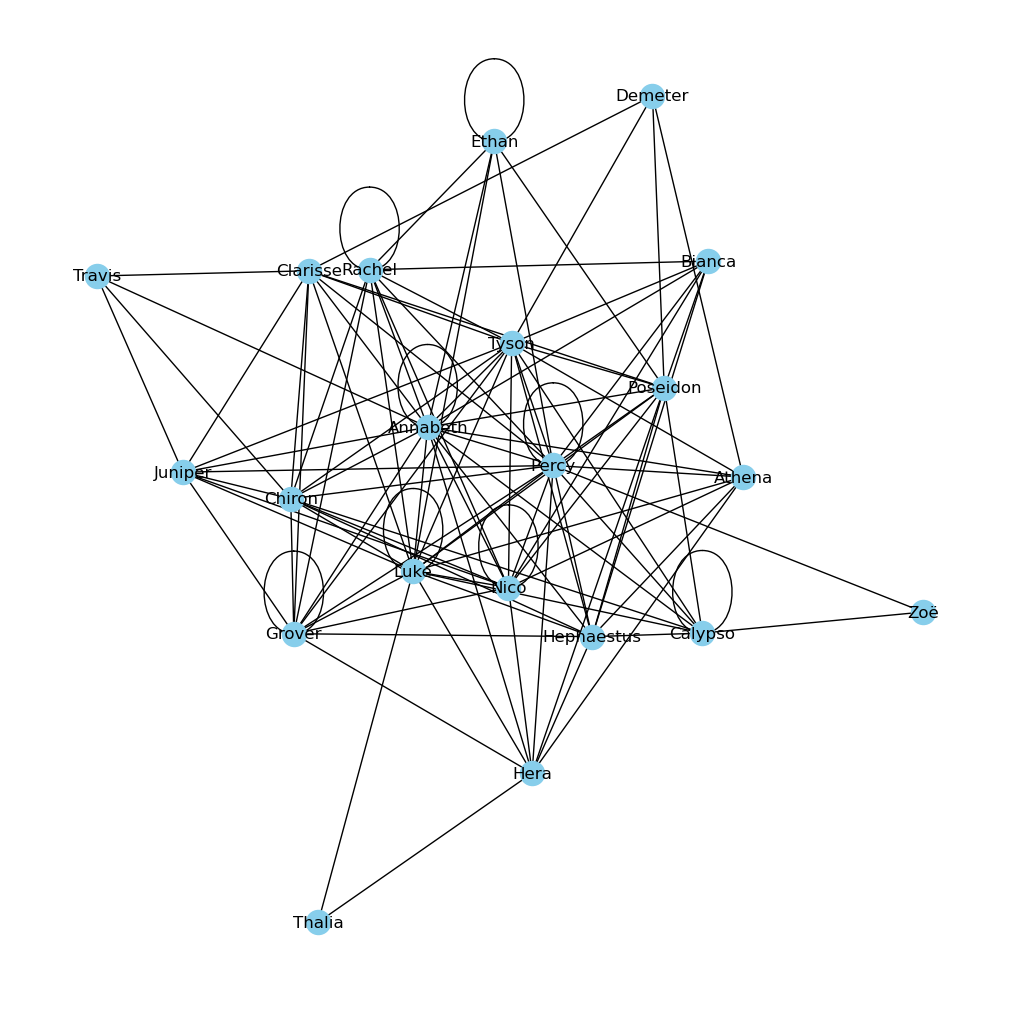

html_files/battle_of_the_labyrinthcommunity.html


progress: 10333it [02:01, 85.12it/s] 


3151


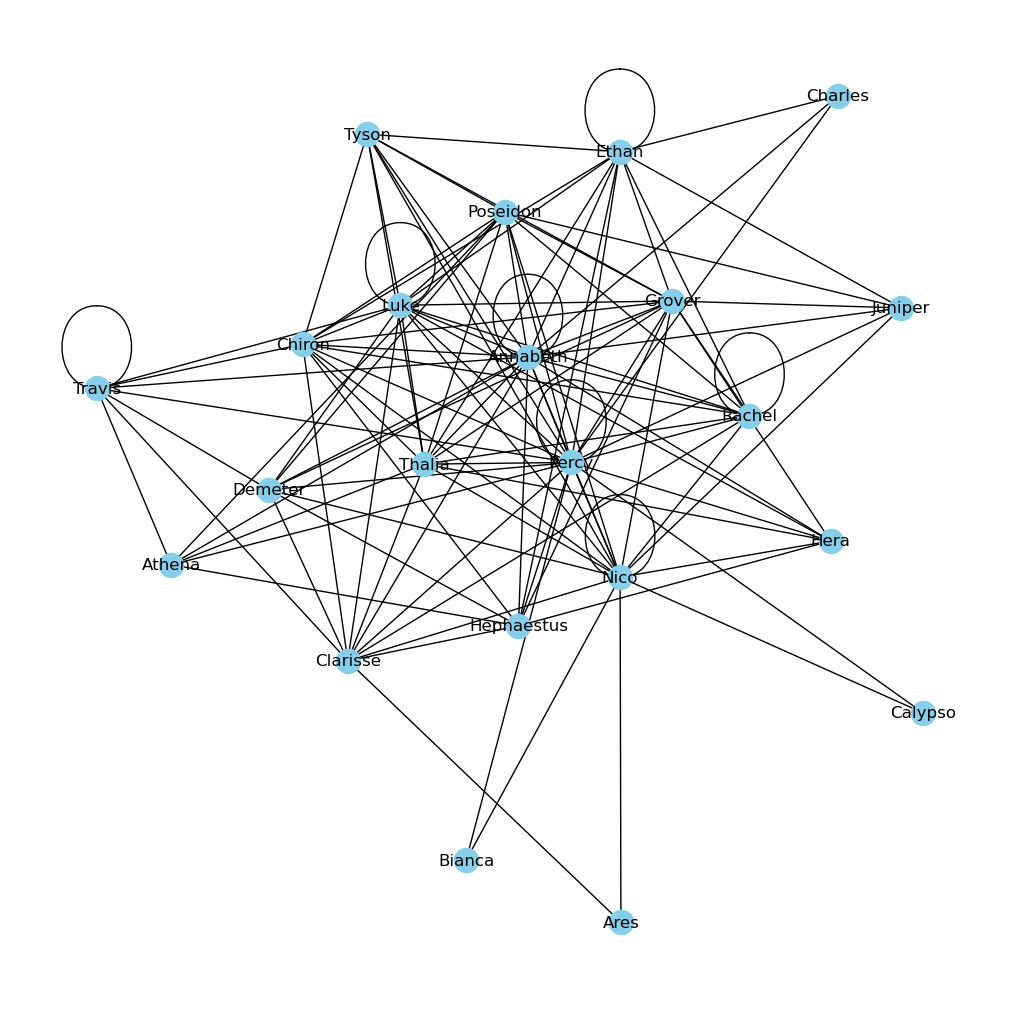

html_files/the_last_olympiancommunity.html


progress: 13115it [03:50, 56.92it/s]


11817


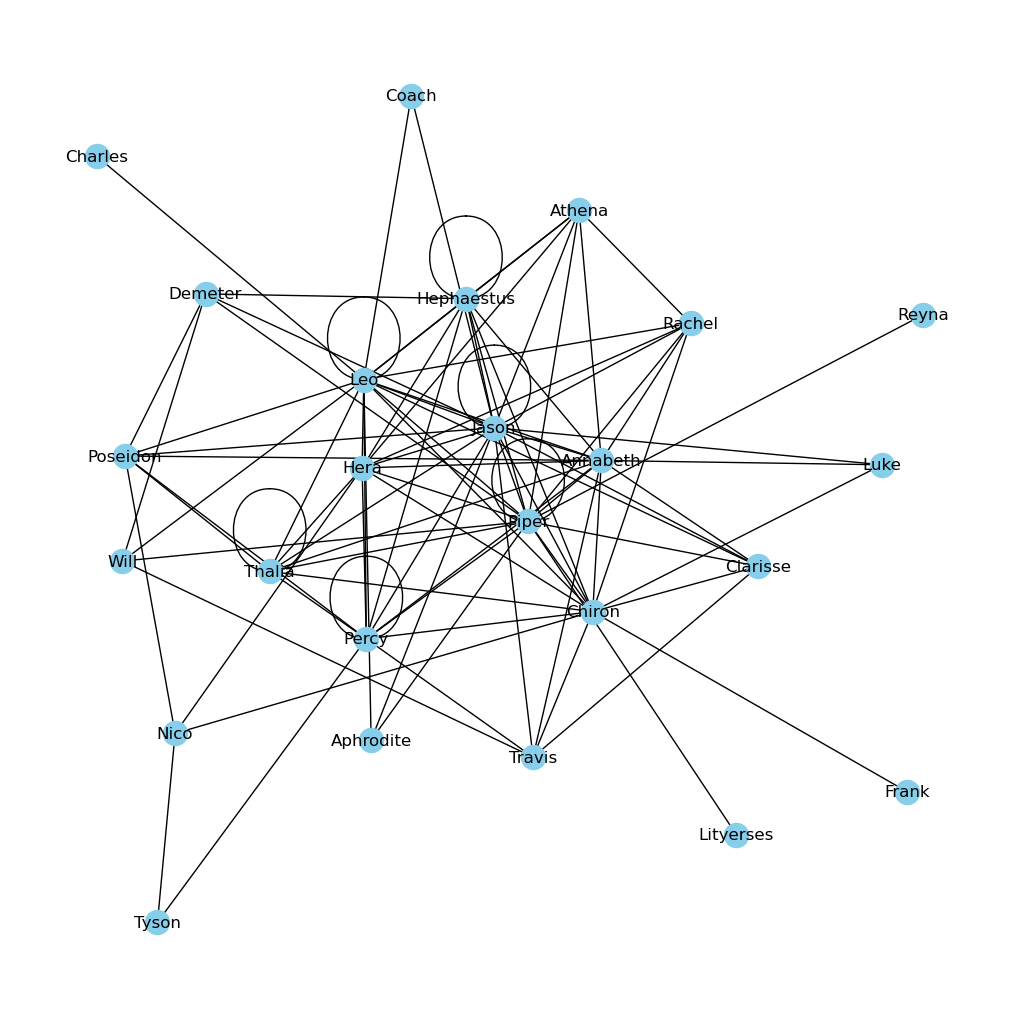

html_files/the_lost_herocommunity.html


progress: 13070it [05:14, 41.52it/s]


10148


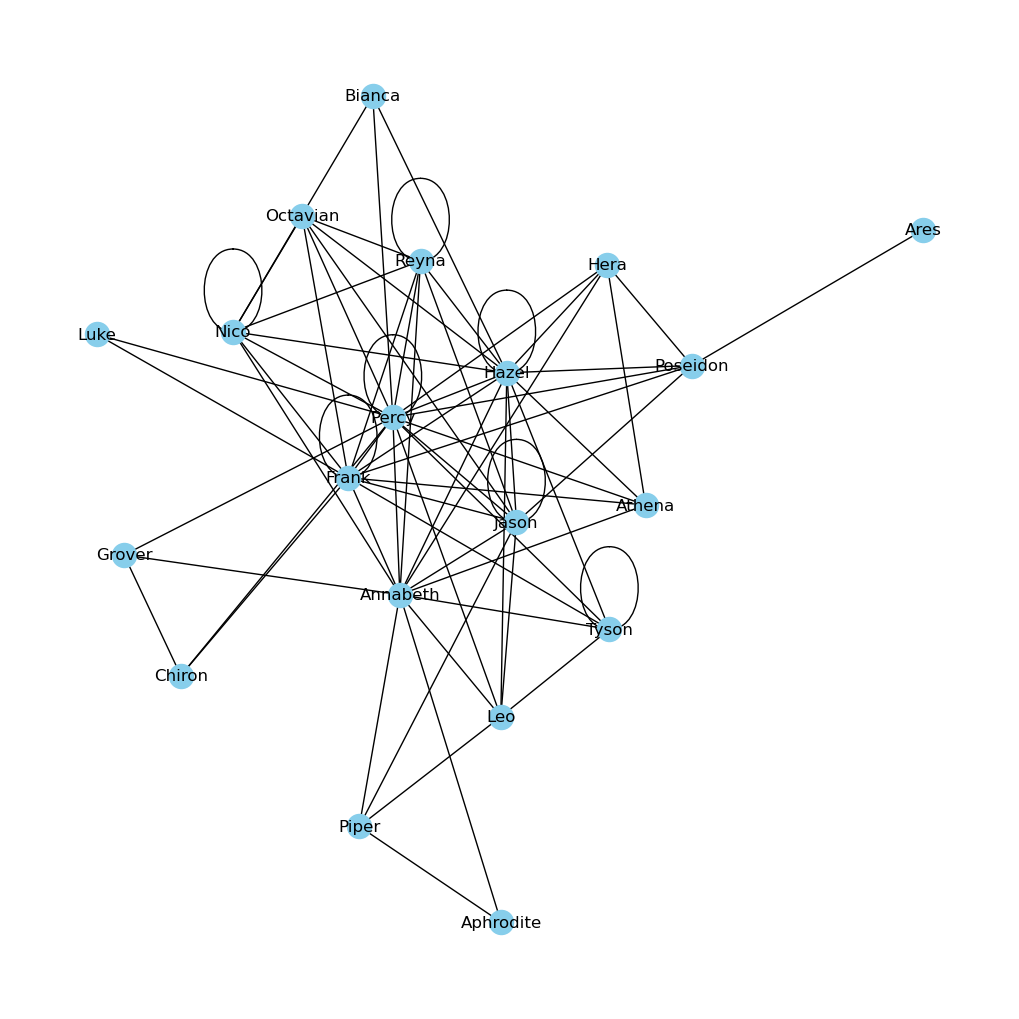

html_files/son_of_neptunecommunity.html


progress: 11039it [03:34, 51.47it/s]


7374


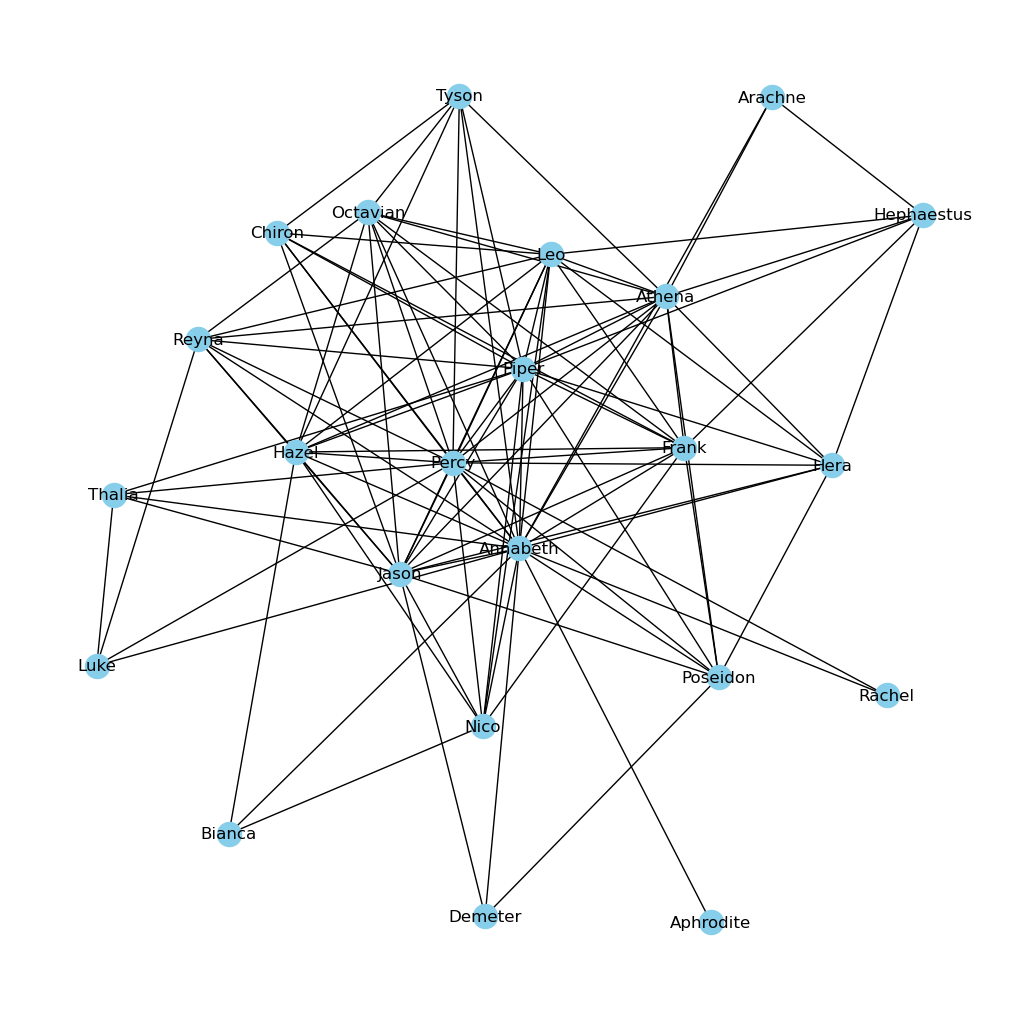

html_files/mark_of_athenacommunity.html


progress: 11489it [03:29, 54.82it/s]


4371


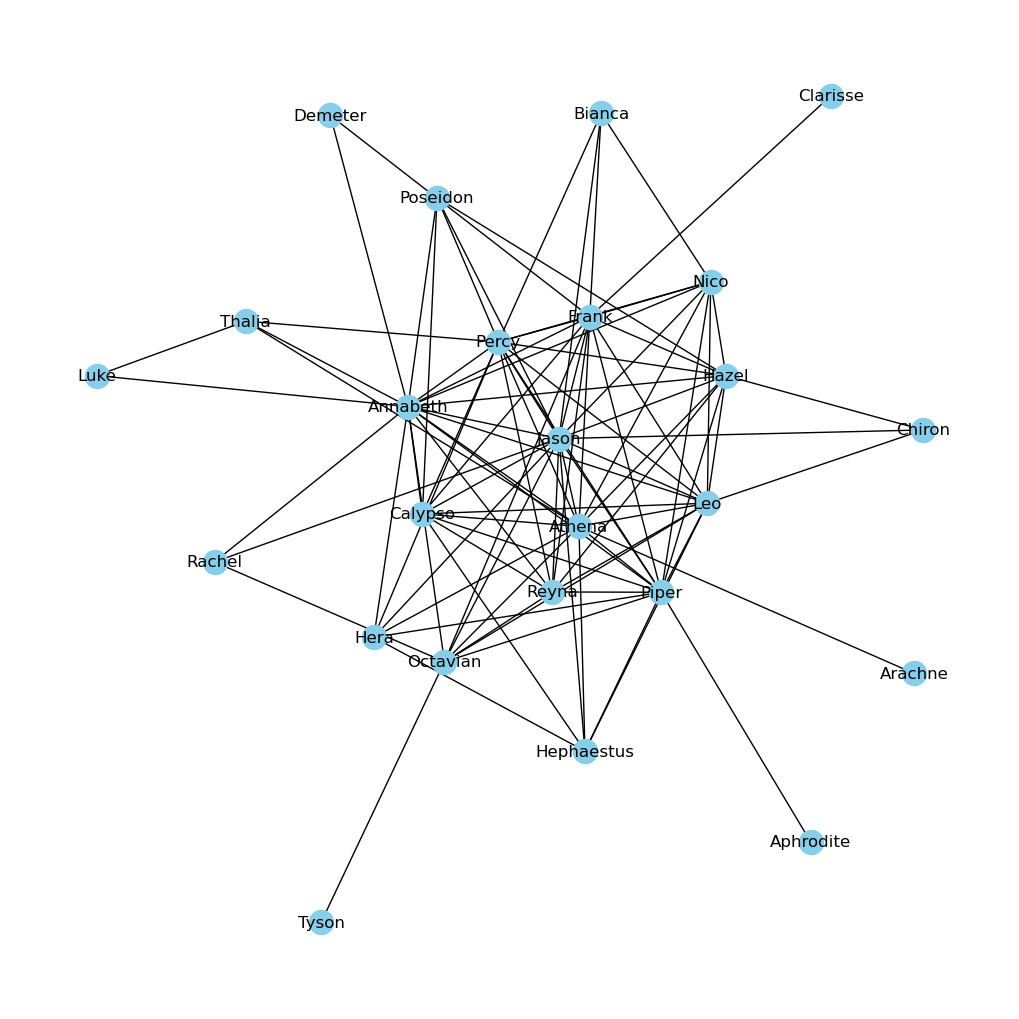

html_files/house_of_hadescommunity.html


progress: 11283it [03:03, 61.46it/s]


8968


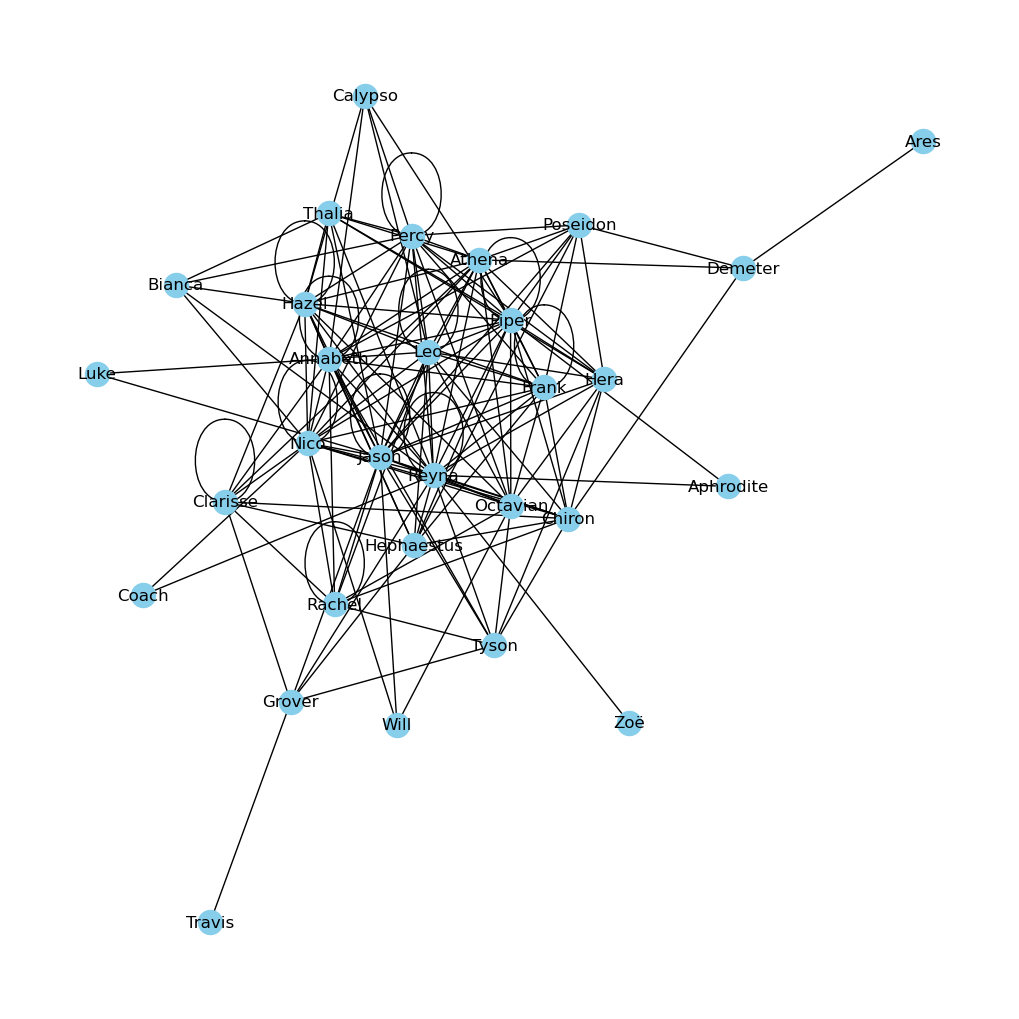

html_files/blood_of_olympuscommunity.html


In [273]:
# Creating a loop for all the books
new_book_names = ['lightening_thief', 'sea_of_monsters', 'titans_curse',
       'battle_of_the_labyrinth', 'the_last_olympian', 'the_lost_hero',
       'son_of_neptune', 'mark_of_athena', 'house_of_hades',
       'blood_of_olympus']


for i in range(10):
    book = all_books[i]
    book_text = open(book).read()
    book_doc = NER(book_text)
    book_title = new_book_names[i]
    sentence_entity_df = []

    for sentence in tqdm(book_doc.sents, 'progress'):
        entity_list = [ent.text for ent in sentence.ents]
        sentence_entity_df.append({'sentance': sentence, 'entity': entity_list})

    sentence_entity_df = pd.DataFrame(sentence_entity_df)

    # Filtering entities
    sentence_entity_df['character_entities'] = sentence_entity_df['entity'].apply(lambda x: filter_entity_list(x, character_df))
    # Filter out sentences that don't have any character entities
    sentence_entity_df_filtered = sentence_entity_df[sentence_entity_df['character_entities'].map(len) > 0]

    # Creating relationships
    window_size = 5
    relationships = []

    for i in range(sentence_entity_df_filtered.index[-1]):
        end_i = min(i+5, sentence_entity_df_filtered.index[-1])
        char_list = sum((sentence_entity_df_filtered.loc[i: end_i].character_entities), [])
        
        # Remove duplicate characters that are next to each other
        char_unique = [char_list[i] for i in range(len(char_list)) 
                    if (i==0) or char_list[i] != char_list[i-1]]
        
        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})

    relationship_df = pd.DataFrame(relationships)
    pd.set_option('display.max_rows', None)
    print(len(relationship_df))
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)

    # Apply the replacement function to the DataFrame
    new_df = replace_names_with_contains(relationship_df[['source', 'target']], list(character_df['character_firstname']))

    # Calculating Interactions
    new_df["value"] = 1
    relationship_df = new_df.groupby(["source","target"], sort=False, as_index=False).sum()

    create_graph(relationship_df, book_title)